## BPR-MF model

In [ ]:
import numpy as np
import pandas as pd
from collections import defaultdict
import matplotlib.pyplot as plt
from datetime import datetime

from tqdm.notebook import tqdm

import warnings, random
warnings.filterwarnings('ignore')

In [ ]:
!wget -q --show-progress https://github.com/sparsh-ai/stanza/raw/S629908/rec/CDL/data/ml_100k_train.npy

In [ ]:
# data loading
train = np.load('ml_100k_train.npy')

In [ ]:
train.shape

(943, 1682)

In [ ]:
train = np.array(train > 0, dtype=float)

In [ ]:
class Config:
    learning_rate = 0.01/2
    weight_decay = 0.1/2
    early_stopping_round = 0
    epochs = 50
    seed = 1995
    dim_f = 20
    alpha = 100
    bootstrap_proportion = 0.5
    
config = Config()

In [ ]:
def item_per_user_dict(data):
    item_per_user = defaultdict(list)
    user_pos = np.nonzero(data != 0)[0]
    item_pos = np.nonzero(data != 0)[1]
    
    for u, i in zip(user_pos, item_pos):
        item_per_user[u].append(i)

    return item_per_user

In [ ]:
class BPR_MF:
    def __init__(self, data):
        self.data = data
        self.user_num = data.shape[0]
        self.item_num = data.shape[1]
        self.user_pos = data.nonzero()[0]
        self.item_pos = data.nonzero()[1]

        self.train_hist = defaultdict(list) 
        self.valid_hist = defaultdict(list)

        self.W = np.random.standard_normal((self.user_num, config.dim_f))
        self.H = np.random.standard_normal((self.item_num, config.dim_f))

    def sampling_uij(self, item_per_user):
        u = np.random.choice(self.user_num)
        rated_items = item_per_user[u]
        i = np.random.choice(rated_items)
        j = np.random.choice(self.item_num)

        return u, i, j, rated_items

    def fit(self):
        train_per_user, test_per_user = self.train_test_split(self.data)

        n = len(self.user_pos)
        for epoch in range(config.epochs):
            preds = []
            num_update_per_epoch = 0
            while num_update_per_epoch <= n*config.bootstrap_proportion:
                u, i, j, rated_items = self.sampling_uij(train_per_user)
                if j not in rated_items:
                    xuij = self.gradient_descent(u, i, j)        
                    num_update_per_epoch += 1    
                    preds.append(xuij)

            auc = np.where(np.array(preds) > 0, 1, 0).mean()
            auc_vl = self.evaluate(train_per_user, test_per_user)
            self.train_hist[epoch] = auc; self.valid_hist[epoch] = auc_vl
            if epoch == 0 or (epoch + 1) % 10 == 0:
                print(f'EPOCH {epoch+1} TRAIN AUC: {auc}, TEST AUC {auc_vl}')
    
    def scoring(self, u, i, j):
        xui = np.dot(self.W[u, :], self.H[i, :])
        xuj = np.dot(self.W[u, :], self.H[j, :])
        xuij = np.clip(xui - xuj, -500, 500)
        
        return xui, xuj, xuij 
    
    def gradient(self, u, i, j):
        xui, xuj, xuij = self.scoring(u, i, j)
        common_term = np.exp(-xuij) / (np.exp(-xuij) + 1)
        
        dw = common_term * (self.H[i, :] - self.H[j, :]) + config.weight_decay*self.W[u, :]
        dhi = common_term * self.W[u, :] + config.weight_decay*self.H[i, :]
        dhj = common_term * -self.W[u, :] + config.weight_decay*self.H[j, :]
        return dw, dhi, dhj, xuij
    
    def gradient_descent(self, u, i, j):
        dw, dhi, dhj, xuij = self.gradient(u, i, j)

        self.W[u, :] = self.W[u, :] + config.learning_rate*dw
        self.H[i, :] = self.H[i, :] + config.learning_rate*dhi
        self.H[j, :] = self.H[j, :] + config.learning_rate*dhj
        return xuij

    def train_test_split(self, data):
        train_per_user = item_per_user_dict(data)
        test_per_user = {}
        for u in range(self.user_num):
            temp = train_per_user[u]
            length = len(temp)
            test_per_user[u] = temp.pop(np.random.choice(length))
            train_per_user[u] = temp

        return train_per_user, test_per_user

    def evaluate(self, train_per_user, test_per_user):
        X = np.dot(self.W, self.H.T)
        item_idx = set(np.arange(self.item_num))
        auc = []
        for u in range(self.user_num):
            i = test_per_user[u]
            j_s = list(item_idx - set(train_per_user[u]))
            auc.append(np.mean(np.where(X[u, i] - X[u, j_s] > 0, 1, 0)))
        return np.mean(auc)

    def plot_loss(self):
        fig, ax = plt.subplots(1,1, figsize=(10, 5))
        
        ax.plot(list(self.train_hist.keys()), list(self.train_hist.values()), color='orange', label='train')
        ax.plot(list(self.valid_hist.keys()), list(self.valid_hist.values()), color='green', label='valid')
        plt.legend()
        plt.show()

In [ ]:
model = BPR_MF(train)
model.fit()

EPOCH 1 TRAIN AUC: 0.5084122896927576, TEST AUC 0.4918741410406097
EPOCH 10 TRAIN AUC: 0.5789355266118347, TEST AUC 0.49335885513555405
EPOCH 20 TRAIN AUC: 0.6905077373065673, TEST AUC 0.5449875003682749
EPOCH 30 TRAIN AUC: 0.7896052598685033, TEST AUC 0.6297262621471355
EPOCH 40 TRAIN AUC: 0.8423789405264869, TEST AUC 0.6790127307629023
EPOCH 50 TRAIN AUC: 0.8587535311617209, TEST AUC 0.6915659424433965


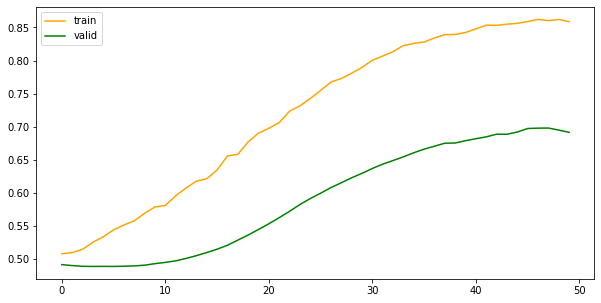

In [ ]:
model.plot_loss()

---

In [ ]:
!pip install -q watermark
%reload_ext watermark
%watermark -a "Sparsh A." -m -iv -u -t -d

Author: Sparsh A.

Last updated: 2021-11-28 15:57:49

Compiler    : GCC 7.5.0
OS          : Linux
Release     : 5.4.104+
Machine     : x86_64
Processor   : x86_64
CPU cores   : 2
Architecture: 64bit

IPython   : 5.5.0
numpy     : 1.19.5
pandas    : 1.1.5
matplotlib: 3.2.2



---

**END**